<a href="https://colab.research.google.com/github/eileenrmartin/IntroToDASData/blob/master/BradyHotSprings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example with Brady Hot Springs Vibroseis



****TO DO: ADD BACKGROUND INFO AND REFERENCES ON BRADY HOT SPRINGS

The Python packages we'll use are:

*   numpy, already available in Colab: ***TO DO: ADD DOCUMENTATION LINK
*   matplotlib.pyplot, already available in Colab: ***TO DO: ADD DOCUMENTATION/GALLERY LINK
*   obspy, needs to be installed: ***TO DO: ADD REFERENCE AND DOCUMENTATION LINI
*   scipy.fftpack, already available in Colab: ***TO DO:  ADD DOCUMENTATION LINK
*   csv, already available in Colab: ****TO DO: ADD DOCUMENTATION LINK
*   ipywidgets, already available in  Colab: ***TO DO: ADD DOCUMENTATION LINK

To run a bash (command-line) command in a Jupyter notebook on Colab, use an ! before the command. Below is the command to install obspy. 



In [1]:
!pip install obspy

All packages need to be imported before they can be used. Now that we've installed Obspy, let's load all relevant packages.

In [2]:
import numpy as np
import scipy.fftpack as ft
import matplotlib.pyplot as plt
import obspy
import csv
import ipywidgets as widgets

# Reading Array Geometry

Grab csv (comma separated value) data from Geothermal Data Repository. File is at url: https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv and more info is at https://openei.org/doe-opendata/dataset/brady-s-geothermal-field-das-and-dts-surface-and-borehole-array-metadata/resource/f0000003-58cc-4372-a567-000000000829

Note that you could download this csv file to your laptop and ready it like an Excel file should you wish. 

In [3]:
!wget https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv

--2020-07-31 14:55:10--  https://gdr.openei.org/files/829/Surface_DAS_DTS_UTM_coordinates.csv
Resolving gdr.openei.org (gdr.openei.org)... 54.189.151.23, 52.27.59.5, 54.186.144.32
Connecting to gdr.openei.org (gdr.openei.org)|54.189.151.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 307372 (300K) [application/octet-stream]
Saving to: ‘Surface_DAS_DTS_UTM_coordinates.csv.5’

Surface_DAS_DTS_UTM 100%[===================>] 300.17K  1.19MB/s    in 0.2s    

2020-07-31 14:55:10 (1.19 MB/s) - ‘Surface_DAS_DTS_UTM_coordinates.csv.5’ saved [307372/307372]



Read the geometry data:

In [4]:
geomData = 'Surface_DAS_DTS_UTM_coordinates.csv'
# for this experiment,  some of the geometry is in this csv file, and some is described on the website
# location of a vibroseis source
srcX = 328552.49 
srcY = 4408006.65 
# if you  look in CSV file, these are the first and last rows with channels that have a location assigned
minRow = 53 
maxRow = 8673  
# read the geometry of all channels in the CSV file
with open(geomData) as myFile:
        myReader = csv.reader(myFile, delimiter=',')
        nRows = maxRow - minRow + 1
        ch = np.zeros(nRows,dtype=np.int) # array to hold channel indices
        x = np.zeros(nRows,dtype=np.float32) # array to hold x location
        y = np.zeros(nRows,dtype=np.float32) # array to hold y location
        myFile.seek(0)
        rowCtr = 1
        for row in myReader:
                if((rowCtr >= minRow) and (rowCtr <= maxRow)):
                        ch[rowCtr-minRow] = int(row[0])
                        x[rowCtr-minRow] = float(row[1])
                        y[rowCtr-minRow] = float(row[2])
                rowCtr = rowCtr + 1

Plot the geometry data checking distances along one subset: 



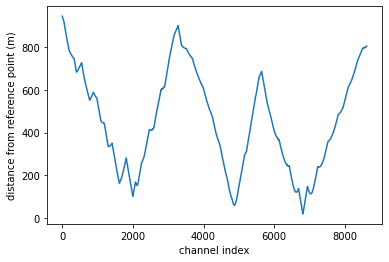

In [5]:
distances = np.sqrt((x-srcX)**2 + (y-srcY)**2)
plt.plot(distances)
plt.xlabel("channel index")
plt.ylabel("distance from reference point (m)")
plt.show()

8650
30


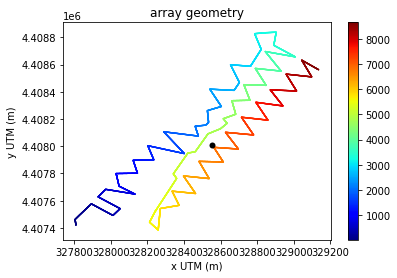

In [6]:
maxCh = np.max(ch)
minCh = np.min(ch)
print(maxCh)
print(minCh)
# location of source from https://gdr.openei.org/submissions/849
# converted to UTM by https://www.latlong.net/lat-long-utm.html
plt.scatter(x,y,c=ch,linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') # ******fix x-ticks
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0)
plt.show()

Grab a vibroseis sweep. More info at http://search.geothermaldata.org/dataset/98046653-40ef-4274-96e5-56bb8ae4dbde


In [8]:
!wget https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy

--2020-07-31 14:55:12--  https://gdr.openei.org/files/849/PoroTomo_iDAS16043_160325140048.sgy
Resolving gdr.openei.org (gdr.openei.org)... 54.186.144.32, 54.189.151.23, 52.27.59.5
Connecting to gdr.openei.org (gdr.openei.org)|54.186.144.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048616640 (1000M) [application/octet-stream]
Saving to: ‘PoroTomo_iDAS16043_160325140048.sgy.5’

PoroTomo_iDAS16043_ 100%[===================>]   1000M  29.6MB/s    in 34s     

2020-07-31 14:55:46 (29.2 MB/s) - ‘PoroTomo_iDAS16043_160325140048.sgy.5’ saved [1048616640/1048616640]



In [24]:
chNumberFor0thTrace = -20 # had to look in the csv file to know this (specific to this dataset's channel/geometry mapping info)
startTrNumber = minRow # for full array # for just one segment you could instead use 5275 to 5490
endTrNumber =  maxRow # for full array 

# create an empty 2D numpy array to store data 
# (rows correspond to channel, columns correspond to time)
data = np.zeros((endTrNumber-startTrNumber+1,nSamples))

# open up the SEGY file
datafile = "PoroTomo_iDAS16043_160325140048.sgy"
st = obspy.read(datafile,format='SEGY')

# get header info from first channel of interest
stats = st[startTrNumber].stats
samplesPerSecond = stats.sampling_rate
secondsPerRecord = stats.npts*stats.delta

# read data from all channels and store in the numpy array
for tr in range(startTrNumber,endTrNumber+1):
	data[tr-startTrNumber,:] = st[tr].data

AttribDict({'textual_file_header': b'C01 Client: Uni. Wisconsin                                                      C02 Field: PoroTomo                                                             C03 Fibre: Trenched Surface Fibre                                               C04 Data collected by Silixa iDAS, Distributed Fibre Optic Sensor               C05 iDAS S/N: iDAS16043                                                         C06 SEGY Format: Rev.1, IEEE 32bit float, big endian                            C07 Field Recording Filename: DAS__160325140048.tdms                            C08 Continuous acquisition data converted to SEGY                               C09 UTC Timestamp of first sample: 25-Mar-2016 14:00:48.754295820               C10                                                                             C11                                                                             C12                                                                             C13

Let's visualize one of these channels (traces) with a wiggle plot:

*****TO DO: FIGURE OUT WHY THIS  MAKES TWO  PLOTS INSTEAD OF ONE?*****

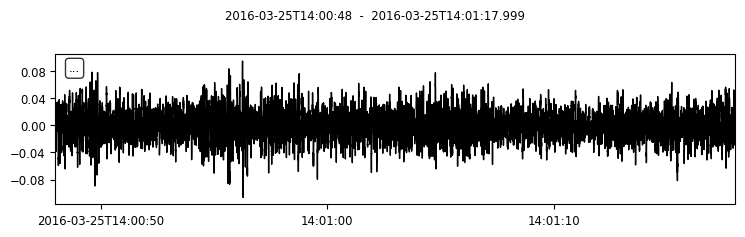

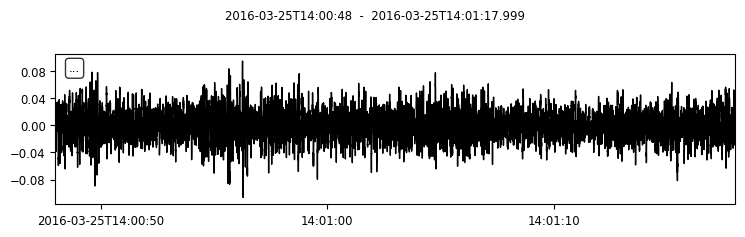

In [22]:
st[startTrNumber].plot()

However, visualizing wiggles from a stream with thousands of traces would be difficult: crowded looking, and taking a long time to generate. Often in array  seismology, we use raster plots rather than wiggles to visualize many traces together. Define a function to plot an array of data from minCh to maxCh, and from minSec seconds to maxSec seconds with a title on the plot.

Here we'll use the seismic colormap (red - white - blue), with one pixel colored to indicate the strain rate at each time sample and channel. Other colormaps can be used for a variety of visualizations: 
TO DO ***** ADD REFERENCE TO NUMPY Colormaps


PURPOSE: 
This function plots a subset of someData from channel minCh to maxCh and minSec to maxSec seconds of time.

INPUTS: 
* someData: *** (0th axis is channel, 1st axis is time)
* minSec: ***
* maxSec: ***
* minCh: ***
* maxCh: ****
* title: a string ***
* sampleRate: a float indicating number of samples per second (of each sensor)

In [10]:
def plotSpaceTime(someData,minSec,maxSec,minCh,maxCh,title,sampleRate):

  # ****TO DO : add error checking***
  
  minSecID = int(minSec*sampleRate) # turn time (in seconds) to index
  maxSecID = int(maxSec*sampleRate) # turn time (in seconds) to index
  plt.figure()
  plt.imshow(someData[minCh:maxCh,minSecID:maxSecID],aspect='auto',interpolation='none',cmap='seismic',extent=(minSec,maxSec,maxCh,minCh))
  plt.xlabel('time (s)')
  plt.ylabel('channel')
  plt.title(title)
  plt.colorbar()

Now call this for the vibroseis sweep record.

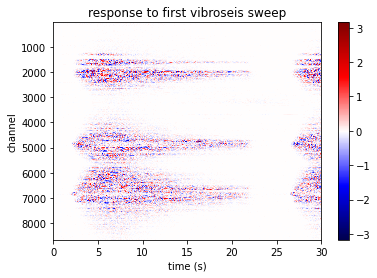

In [11]:
title='response to first vibroseis sweep'
beginningCh = startTrNumber+chNumberFor0thTrace
endingCh =  endTrNumber+chNumberFor0thTrace
plotSpaceTime(data, 0, secondsPerRecord, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

Write a function to plot a snapshot of  the wavefield in time with a colored marker at each channel location. Each marker color should indicate the strain rate at the particular time and location.

INPUTS: ****TO DO: fill this out
* xLocs: ***
* yLocs: ***
* dataChT: ***
* timeInSeconds: ***
* sampleRate: ***
* subsample: ***** if = 1 (default) no spatial subsampling is done
* clip: ****
No outputs, just generates a figure.

In [12]:
def plotTimeSnapshot(xLocs, yLocs, dataChT, timeInSeconds, sampleRate, subsample=1, clip=0):
  # TO DO: add a little error checking on the inputs *******

  # time sample of interest
  timeID = int(timeInSeconds*sampleRate)

  # default color clipping behavior is to just set the max color value to the max absolute value in this snapshot
  if(clip == 0):
    clip = np.max(np.absolute(dataChT[:,timeID])) 

  plt.figure()
  plt.scatter(xLocs[::subsample],yLocs[::subsample],c=dataChT[::subsample,timeID],linewidth=0,s=2,cmap='seismic',vmin=-clip,vmax=clip)
  plt.colorbar()
  plt.xlabel('x UTM (m)')
  plt.locator_params(axis='x', nbins=5) # reduce number of tick marks so labels aren't so crowded
  plt.ylabel('y UTM (m)')
  plt.title('signal at '+str(timeInSeconds)+' seconds',fontsize=14)

Plot a snapshot of the wavefield at a particular time, 3.5 seconds for example.

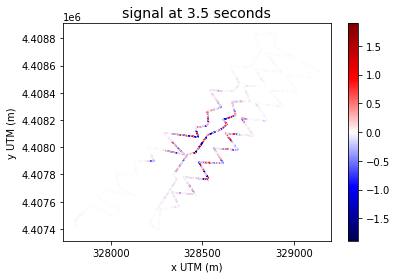

In [13]:
time = 3.5 # time of intereset (in seconds)
plotTimeSnapshot(x, y, data, time, samplesPerSecond)

We can use a widget to easily change the time of the snapshot. 

Note: it does take a little time to regenerate each one, so if you're impatient you may want to set subsample to an integer > 1 (so for instance is subsample = 10, then only every 10th channel will be plotted).

In [14]:
# set a single  color clip for all time snapshots (so they're all on the same colorscale)
overallClip  = np.percentile(np.absolute(data),99) # take the 99th %tile of absolute values of whole data window as max

def interactiveSnapshot(timeInSec):
  # This is a wrapper around plotTimeSnapshot so that the widget just depends on the 
  # time of interest in seconds. This has no subsampling (so 2nd to last arg is 1).
  plotTimeSnapshot(x, y, data, timeInSec, samplesPerSecond, 1, overallClip)

# has a widget that lets you check the time snapshot at 1, 1.5, 2, 2.5, ..., 24.5, 25 seconds
interactive_plot = widgets.interactive(interactiveSnapshot, timeInSec=(1,25,0.5)) 
interactive_plot

interactive(children=(FloatSlider(value=13.0, description='timeInSec', max=25.0, min=1.0, step=0.5), Output())…

## Effect of sensor orientation on  response

Let's zoom in on just channels 1500-2500 during 7-8 seconds while . These channels make a few tight turns, so they'll let us see how response varies with geometry. First check  out this subset of the geometry.

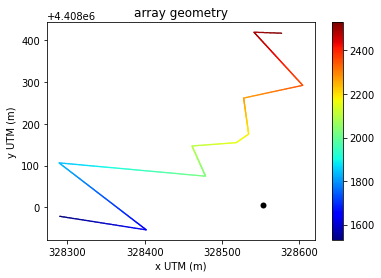

In [15]:
startCh = 1500
endCh = 2500
startSec = 7
endSec = 8

plt.scatter(x[startCh:endCh],y[startCh:endCh],c=ch[startCh:endCh],linewidth=0,s=2,cmap=plt.get_cmap('jet'))
plt.colorbar()
plt.xlabel('x UTM (m)') 
plt.locator_params(axis='x', nbins=5)
plt.ylabel('y UTM (m)')
plt.title('array geometry')
plt.scatter(srcX,srcY,c='k',linewidth=0) # plot the source location
plt.show()

Now actually plot the data. Investigate where the corners of the array line up with the data, and the direction of the waves moving outwards from the source. What do you notice?



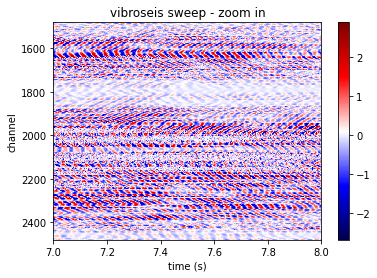

In [16]:
title='vibroseis sweep - zoom in'
beginningCh = startCh+chNumberFor0thTrace
endingCh =  endCh+chNumberFor0thTrace
plotSpaceTime(data, startSec, endSec, beginningCh, endingCh, title, samplesPerSecond) # call the actual plotting function

**Array geometry questions for small group investigation:**

1. Look at the last segment. How would waves from that source location be hitting it? What do you notics about the amplitudes?
2. Why is the amplitude from ~1750 to ~1900 so much lower than 1500 to ~1650 even though it is closer to the source? 
3. Change your visualization codes in the cell above and below so you can zoom in on much smaller subsets of channels. Can you figure out where corners are based on the waveforms?
4. Try zooming in on different subsets of the array. What do you see about their response? 

## Spectral Analysis

****ADD text to introduce looking at spectrum during vibroseis sweep and have references to fourier transform info and  documentation for scipy's 1D and 2D Fourier transforms*

In the cell below, we define a function to calculate the power spectrum of a single channel's recording.

In [17]:
def plotSpecOneCh(chOfInterest,dataArray,sampleRate,title): 
  # ****TO DO: add error checking on inputs***

  spectrum = ft.fft(dataArray[chOfInterest,:])
  frqBins = int(spectrum.size/2)
  # frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  frqs = np.linspace(0,NyquistFrq,num=frqBins)

  plt.figure()
  plt.plot(frqs,np.absolute(spectrum[:frqBins]))
  plt.xlabel('Frequency (Hz)',fontsize=12)
  plt.ylabel('Amplitude',fontsize=12)
  plt.title(title)


Let's plot this for one particular  channel of interest, 2300 (remember to offset by the index in data of the  0th  channel).

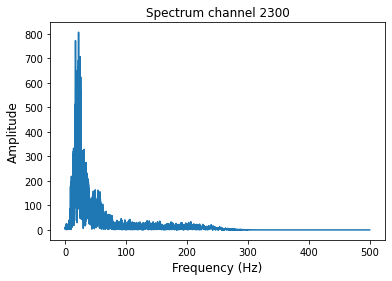

In [18]:
ch = 2300
plotSpecOneCh(ch+chNumberFor0thTrace,data,samplesPerSecond,'Spectrum channel '+str(ch))

Define a function that will plot the amplitude spectrum of each channel (amplitude indicated by color) within a certain time window and frequency range.


INPUTS: ******complete this*****
* dataArray: ****
* minSec: ****
* maxSec:  ****
* minCh: ***
* maxCh: ***
* minFrq: ***
* maxFrq:  ***
* sampleRate: ***
* title: ***
* scale: keyword****

In [19]:
def plotArraySpec(dataArray, minSec, maxSec, minCh, maxCh, minFrq, maxFrq, sampleRate, title,  scale='linear'):

  # check for valid inputs (note- these checks aren't exhaustive)
  if(maxFrq <= minFrq):
    print("ERROR in plotArraySpec inputs: minFrq "+str(minFrq)+" >= maxFrq "+str(maxFrq))
    return
  if maxSec <= minSec:
    print("ERROR in plotArraySpec inputs: minSec "+str(minSec)+" >= maxSec "+str(maxSec))
    return
  if (scale != 'linear')  and (scale  != 'log10'):
    print("ERROR  in plotArraySpec inputs: scale keyword "+scale+" is not recognized")

  # figure out sample indices for time window of interest
  startTimeIdx =  int(minSec*sampleRate)
  endTimeIdx = int(maxSec*sampleRate)
  if endTimeIdx > dataArray.shape[1]:
    print("ERROR in plotArraySpec inputs: maxSec "+str(maxSec)+" exceeds last time in dataArray")

  # calculate the amplitude spectrum (not amplitude symmetry for +/- frequencies)
  spectrum = ft.fft(dataArray[minCh:maxCh+1,startTimeIdx:endTimeIdx+1],axis=-1) 
  nFrqBins = int(spectrum.shape[1]/2) # number of frequency bins 
  amplitudeSpec =np.absolute(spectrum[:,:nFrqBins])

  # calculate indices corresponding to the frequencies of interest
  NyquistFrq = sampleRate/2.0 # the Nyquist frequency
  # make sure maxFrq doesn't exceed Nyquist  frequency
  if(maxFrq > NyquistFrq):
    print("ERROR in plotArraySpec inputs: maxFrq "+str(maxFrq)+" >= Nyquist frequency "+str(NyquistFrq)+" indicated by sampleRate "+str(sampleRate))
    return
  # convert frequencies to an index in the array
  HzPerBin = NyquistFrq/float(nFrqBins) 
  minFrqIdx =  int(minFrq/HzPerBin) 
  maxFrqIdx =  int(maxFrq/HzPerBin)
  frqs = np.linspace(minFrqIdx*HzPerBin,maxFrqIdx*HzPerBin,num=(maxFrqIdx-minFrqIdx+1))

  # actually do the plot
  plt.figure()
  if scale  == 'linear':
    plt.imshow(amplitudeSpec,aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  elif scale == 'log10':
    plt.imshow(np.log10(amplitudeSpec),aspect='auto',interpolation='none',cmap='inferno',extent=(minFrq,maxFrq,maxCh,minCh)) 
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('Channel')
  plt.colorbar()
  plt.title(title)


Let's first look at all channels' amplitude spectra up to a few hundred Hz for the entire sweep (say 0 to 25 seconds):

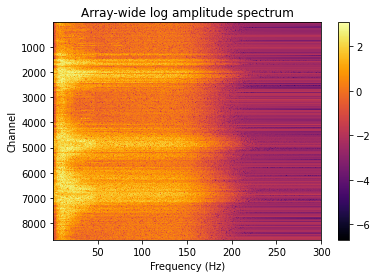

In [20]:
# visualize same channels as you did for whole time domain plot above
beginningCh = startTrNumber+chNumberFor0thTrace
endingCh =  endTrNumber+chNumberFor0thTrace
# choose frequency range of interest
minFrq = 0.5
maxFrq = 300
# choose which time window to investigate
startSec =  0
endSec = 25
# call the function to plot
plotArraySpec(data, startSec, endSec, beginningCh, endingCh, minFrq, maxFrq, samplesPerSecond, 'Array-wide log amplitude spectrum','log10')

***Spectral analysis questions for small group investigation:***

Add some cells to look at different subsets of the frequency content, subsets in time, and in space. Investigate some of the following questions:
1. During this vibroseis sweep how does the frequency content change over time?
2. How does the frequency content differ on channels that are closer to the  source? Farther from the source? 
3. Does the geometry matter in the frequency content acquired on a channel? 
4. How much does the colormap matter in your ability to visualize these changes? Investigate this by changing the cmap parameter (maybe even add it as a parameter in the function call).
5. Within a single channel, we often use a "waterfall plot" that shows the spectral amplitude after calculating the short time Fourier transform in many shorter successive time windows. Try to code this up and use it to investigate changes over time on different channels. 